In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import os
import math
import collections
import re
from scipy.stats import pearsonr

#comment: for server only
# import matplotlib
# matplotlib.use('Agg') 

import matplotlib.pyplot as plt
import timeit

start = timeit.default_timer()



# Model Hyperparameters
flags=tf.flags

flags.DEFINE_string('word2vec_path','embeddings/GoogleNews-vectors-negative300.txt','Word2vec file with pre-trained embeddings')
flags.DEFINE_string('data_path','data','data set path')
flags.DEFINE_string('min_word_freq','2','Minimum word frequency')
flags.DEFINE_string('save_path','model/','STS model output directory')
flags.DEFINE_string('result_path','result/','data set path')
flags.DEFINE_string('test_data',"data/SICK/SICK_test_annotated.txt",'Test data')
flags.DEFINE_string('validation_data',"data/SICK/SICK_new_trial.txt",'Validation data')
flags.DEFINE_string('train_data',"data/SICK/SICK_new_train.txt",'Train data')
flags.DEFINE_string('all_data',"data/SICK/SICK_all.txt",'Train data')
flags.DEFINE_string('cnt',"10",'Number of samples to show')
flags.DEFINE_string('model_name','02','Filename of the model file')
flags.DEFINE_integer('word_embedding_dim',300,'Dimensionality of word embedding')
flags.DEFINE_integer('char_embedding_dim',50,'Dimensionality of char embedding')
flags.DEFINE_bool('use_fp64',False,'Train using 64-bit floats instead of 32bit floats')



FLAGS=flags.FLAGS
FLAGS._parse_flags()
print('Parameters:')
for attr,value in sorted(FLAGS.__flags.items()):
    print('{}={}'.format(attr,value))
    
    

# model parameters
class Config(object):
    init_scale=0.2
    learning_rate=.01
    max_grad_norm=1.
    keep_prob=0.5
    lr_decay=0.98
    batch_size=30
    lr_max_epoch=8##this is for learning rate epoch
    train_max_epoch=5
    num_layer=1
    num_units=50
    patience=5
    
config=Config()
config_gpu = tf.ConfigProto()
config_gpu.gpu_options.allow_growth = True
    
def data_type():
    return tf.float64 if FLAGS.use_fp64 else tf.float32



class Input(object):
    def __init__(self,sentences_A,sentencesA_length,sentences_B,sentencesB_length,relatedness_scores):
        self.sentences_A=sentences_A
        self.sentencesA_length=sentencesA_length
        self.sentences_B=sentences_B
        self.sentencesB_length=sentencesB_length
        self.relatedness_scores=relatedness_scores
    
    def sentences_A(self):
        return self.sentences_A
    
    def sentencesA_length(self):
        return self.sentencesA_length
    
    def sentences_B(self):
        return self.sentences_B
    
    def sentencesA_length(self):
        return self.sentencesB_length
    
    def relatedness_scores(self):
        return self.relatedness_scores


'''
Reads SICK file. Take note of the header line.
'''
def read_input_file(filename):
    with open(filename,'r') as f:
        f.readline() # removes header line/column labels
        sentences_A = []
        sentencesA_length = []
        sentences_B = []
        sentencesB_length = []
        relatedness_scores = []
        while True:
            line=f.readline()
            if not line: break

            sentence_A=line.split('\t')[1]
            sentence_B=line.split('\t')[2]
            relatedness_score=line.split('\t')[3]    
            
            words = sentence_A.split()
            sentencesA_length.append(len(words))
            sentences_A.append(words)
            
            words = sentence_B.split()
            sentencesB_length.append(len(words))
            sentences_B.append(words)
            
            relatedness_scores.append(((float(relatedness_score) - 1) / 4 )) # convert scores to [0,1] values
    assert len(sentences_A)==len(sentencesA_length)==len(sentences_B)==len(sentencesB_length)==len(relatedness_scores)
    return Input(sentences_A,sentencesA_length,sentences_B,sentencesB_length,relatedness_scores)


def generate_word2id_dictionary(texts, min_freq=-1, insert_words=None, lowercase=False, replace_digits=False):
    counter = collections.Counter()
    for text in texts:
        if lowercase:
            text = text.lower()
        if replace_digits:
            text = re.sub(r'\d', '0', text)
        counter.update(text.strip().split())

    word2id = collections.OrderedDict()
    if insert_words is not None:
        for word in insert_words:
            word2id[word] = len(word2id)
    word_count_list = counter.most_common()

    for (word, count) in word_count_list:
        if min_freq <= 0 or count >= min_freq:
            word2id[word] = len(word2id)

    return word2id

# Create an OrderedDict of words and characters and their ids based on their frequency
dataset = read_input_file(FLAGS.all_data)
sentences = dataset.sentences_A + dataset.sentences_B
word2id = generate_word2id_dictionary([" ".join(sentence) for sentence in sentences], 
                                        int(FLAGS.min_word_freq), 
                                        insert_words=["<unk>"], 
                                        lowercase=False, 
                                        replace_digits=False)
char2id = generate_word2id_dictionary([" ".join([" ".join(list(word)) for word in sentence]) for sentence in sentences], 
                                        min_freq=-1, 
                                        insert_words=["<cunk>"], 
                                        lowercase=False, 
                                        replace_digits=False)



## vocab size
word_vocab_size = len(word2id)

char_vocab_size = len(char2id)
print(word_vocab_size, char_vocab_size)





# Given the word2id, load its pretrained vectors into memory
def preload_vectors(word2vec_path, word2id, vocab_size, emb_dim):
    if word2vec_path:
        print('Load word2vec_norm file {}'.format(word2vec_path))
        with open(word2vec_path,'r') as f:
            header=f.readline()
            print(vocab_size, emb_dim)
            scale = np.sqrt(3.0 / emb_dim)
            init_W = np.random.uniform(-scale, scale, [vocab_size, emb_dim])
            
            print('vocab_size={}'.format(vocab_size))
            while True:
                line=f.readline()
                if not line:break
                word=line.split()[0]
                if word in word2id:
                    init_W[word2id[word]] = np.array(line.split()[1:], dtype = "float32")
    return init_W

init_W = preload_vectors(FLAGS.word2vec_path, word2id, word_vocab_size, FLAGS.word_embedding_dim)

print("preloaded vectors")


def map_text_to_ids(text, word2id, start_token=None, end_token=None, unk_token=None, lowercase=False, replace_digits=False):
    ids = []

    if lowercase:
        text = text.lower()
    if replace_digits:
        text = re.sub(r'\d', '0', text)

    if start_token != None:
        text = start_token + " " + text
    if end_token != None:
        text = text + " " + end_token
    for word in text.strip().split():
        if word in word2id:
            ids.append(word2id[word])
        elif unk_token != None:
            ids.append(word2id[unk_token])
    return ids


def read_dataset(filename, lowercase_words, lowercase_chars, replace_digits, word2id, char2id):
    dataset = []
    data = read_input_file(filename)
    sentences = [data.sentences_A, data.sentences_B]
    max_sentence_len = 0
    max_word_len = 0
    for i in range(len(data.sentences_A)):

        # map text to ids
        senA_word_ids = map_text_to_ids(" ".join(sentences[0][i]), word2id, None, None, "<unk>", lowercase=False, replace_digits=False)
        senA_char_ids = [map_text_to_ids(" ".join(list(word)), char2id, None, None, "<cunk>", lowercase=False, replace_digits=False) for word in sentences[0][i]]

        senB_word_ids = map_text_to_ids(" ".join(sentences[1][i]), word2id, None, None, "<unk>", lowercase=False, replace_digits=False)
        senB_char_ids = [map_text_to_ids(" ".join(list(word)), char2id, None, None, "<cunk>", lowercase=False, replace_digits=False) for word in sentences[1][i]]

        assert(len(senA_word_ids) == len(senA_char_ids))
        assert(len(senB_word_ids) == len(senB_char_ids))
        
        
        senA_len = len(senA_word_ids)
        senA_words_len = [len(word) for word in senA_char_ids]
        senB_len = len(senB_word_ids)
        senB_words_len = [len(word) for word in senB_char_ids]
        
        max_sentence_len = max(max_sentence_len, senA_len, senB_len)
        max_word_len = max(max(senA_words_len), max(senB_words_len), max_word_len)
        
        dataset.append((senA_word_ids, senA_len, senA_char_ids, senA_words_len, senB_word_ids, senB_len, senB_char_ids, senB_words_len, data.relatedness_scores[i]))
    return dataset, max_sentence_len, max_word_len

data_train, max_sentence_len_train, max_word_len_train = read_dataset(FLAGS.train_data, False, False, False, word2id, char2id)
data_dev, max_sentence_len_dev, max_word_len_dev = read_dataset(FLAGS.validation_data, False, False, False, word2id, char2id)
data_test, max_sentence_len_test, max_word_len_test = read_dataset(FLAGS.test_data, False, False, False, word2id, char2id)
print("dataset read")

'''
Get the max_sentence_len and max_word_len
'''
## Check the sentence
# max_sentence_len = sorted(([(len(sentence), sentence) for sentence in sentences]))[-1]
max_sentence_len = max(max_sentence_len_train, max_sentence_len_test, max_sentence_len_dev)
print(max_sentence_len)

## Check the word
# max_word_len = sorted(([(len(word), word) for word in word2id]))[-1]
max_word_len = max(max_word_len_train, max_word_len_test, max_word_len_dev)
print(max_word_len)


def pad_to_max_len_sentence_and_word_len(data, max_sentence_len, max_word_len):
    dataset = []

    for i in range(len(data)):

        senA_word_ids = data[i][0]
        senB_word_ids = data[i][4]
        senA_char_ids = data[i][2]
        senB_char_ids = data[i][6]
        senA_words_len = data[i][3]
        senB_words_len = data[i][7]
        senA_len = data[i][1]
        senB_len = data[i][5]
        relatedness_scores = data[i][8]
        
        # pad values to max_sentence_len 
        senA_word_ids += [0] * (max_sentence_len - len(senA_word_ids))
        senB_word_ids += [0] * (max_sentence_len - len(senB_word_ids))
               
        assert(len(senA_word_ids) == len(senB_word_ids))
        
        # pad values to max_word_len and pad each sentence to max_sentence_len
        senA_char_ids_wl = [word + ([0] * (max_word_len - len(word))) for word in senA_char_ids]
        senA_char_ids_sl = [([0] * (max_word_len))] * (max_sentence_len - len(senA_char_ids_wl))
        senA_char_ids = senA_char_ids_wl + senA_char_ids_sl

        senB_char_ids_wl = [word + ([0] * (max_word_len - len(word))) for word in senB_char_ids]
        senB_char_ids_sl = [([0] * (max_word_len))] * (max_sentence_len - len(senB_char_ids_wl))
        senB_char_ids = senB_char_ids_wl + senB_char_ids_sl

        # pad word lengths to max_sentence_len
        senA_words_len = senA_words_len + ([0] * (max_sentence_len - len(senA_words_len)))
        senB_words_len = senB_words_len + ([0] * (max_sentence_len - len(senB_words_len)))
        
        dataset.append((senA_word_ids, senA_len, senA_char_ids, senA_words_len, senB_word_ids, senB_len, senB_char_ids, senB_words_len, relatedness_scores))
    return dataset

data_train = pad_to_max_len_sentence_and_word_len(data_train, max_sentence_len, max_word_len)
data_dev = pad_to_max_len_sentence_and_word_len(data_dev, max_sentence_len, max_word_len)
data_test = pad_to_max_len_sentence_and_word_len(data_test, max_sentence_len, max_word_len)

zipped_train = zip(*data_train)
zipped_dev = zip(*data_dev)
zipped_test = zip(*data_test)
len(zipped_train[3][0])

print("pad_to_max_len_sentence_and_word_len")


def next_batch(start,end,input):
    senA_word_ids = input[0][start:end]
    senA_len = input[1][start:end]
    senA_char_ids = input[2][start:end]
    senA_words_len = input[3][start:end]
    senB_word_ids = input[4][start:end]
    senB_len = input[5][start:end]
    senB_char_ids = input[6][start:end]
    senB_words_len = input[7][start:end]
    relatedness_scores = np.reshape(input[8][start:end],(-1))
    return Batch(senA_word_ids, senA_len, senA_char_ids, senA_words_len, senB_word_ids, senB_len, senB_char_ids, senB_words_len, relatedness_scores)


class Batch(object):
    def __init__(self,senA_word_ids, senA_len, senA_char_ids, senA_words_len, senB_word_ids, senB_len, senB_char_ids, senB_words_len, relatedness_scores):
        self.senA_word_ids = senA_word_ids
        self.senA_len = senA_len
        self.senA_char_ids = senA_char_ids
        self.senA_words_len = senA_words_len
        self.senB_word_ids = senB_word_ids
        self.senB_len = senB_len
        self.senB_char_ids = senB_char_ids
        self.senB_words_len = senB_words_len
        self.relatedness_scores = relatedness_scores
    def senA_word_ids(self):
        return self.senA_word_ids
    
    def senA_len(self):
        return self.senA_len
    
    def senA_char_ids(self):
        return self.senA_char_ids
    
    def senA_words_len(self):
        return self.senA_words_len
    
    def senB_word_ids(self):
        return self.senB_word_ids
    
    def senB_len(self):
        return self.senB_len
    
    def senB_char_ids(self):
        return self.senB_char_ids
    
    def senB_words_len(self):
        return self.senB_words_len
    
    def relatedness_scores(self):
        return self.relatedness_scores





Parameters:
all_data=data/SICK/SICK_all.txt
char_embedding_dim=50
cnt=10
data_path=data
min_word_freq=2
model_name=02
result_path=result/
save_path=model/
test_data=data/SICK/SICK_test_annotated.txt
train_data=data/SICK/SICK_new_train.txt
use_fp64=False
validation_data=data/SICK/SICK_new_trial.txt
word2vec_path=embeddings/GoogleNews-vectors-negative300.txt
word_embedding_dim=300
2556 54
Load word2vec_norm file embeddings/GoogleNews-vectors-negative300.txt
2556 300
vocab_size=2556
preloaded vectors
dataset read
32
16
pad_to_max_len_sentence_and_word_len


build_model
training..
>>: Model/word_embeddings:0
>>: Model/siamese_final/RNN/MultiRNNCell/Cell0/LSTMCell/W_0:0
>>: Model/siamese_final/RNN/MultiRNNCell/Cell0/LSTMCell/B:0
Total batch size: 116, data size: 3499, batch size: 30
1.0 0.5 0.98 8 5 1
Epoch 0 Learning rate: 0.00999999977648
Average cost:	0.000301723111549 >
Valid cost:	0.0474858470261 >
patience: 5
Epoch 1 Learning rate: 0.00999999977648
Average cost:	0.000201588271764 >
Valid cost:	0.0427977032959 >
patience: 5
Epoch 2 Learning rate: 0.00999999977648
Average cost:	0.000145685537879 >
Valid cost:	0.0402670055628 >
patience: 5
Epoch 3 Learning rate: 0.00999999977648
Average cost:	0.000143615978545 >
Valid cost:	0.0382386781275 >
patience: 5
Epoch 4 Learning rate: 0.00999999977648
Average cost:	0.000136315726258 >
Valid cost:	0.03590965271 >
patience: 5
0.034764
Pearson: (0.68566554561803827, 0.0)
Execution time: 1486141652.41


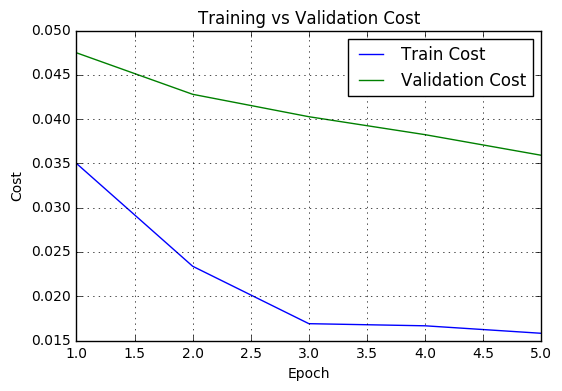

In [3]:


def build_model(input_,input_length,dropout_):##should try this
    rnn_cell=tf.nn.rnn_cell.LSTMCell(config.num_units)##why 50?
    rnn_cell=tf.nn.rnn_cell.DropoutWrapper(rnn_cell,output_keep_prob=dropout_)
    rnn_cell=tf.nn.rnn_cell.MultiRNNCell([rnn_cell]*config.num_layer)
        
    outputs,last_states=tf.nn.dynamic_rnn(
        cell=rnn_cell,
        dtype=data_type(),
        sequence_length=input_length,
        inputs=input_
    )
    return outputs,last_states

print("build_model")
print("training..")

with tf.Graph().as_default():
    initializer=tf.contrib.layers.xavier_initializer()

    with tf.variable_scope('Model',initializer=initializer):
        
        # word embedding
        sentences_A = tf.placeholder(tf.int32, shape = ([None, max_sentence_len]), name='sentences_A')
        sentencesA_length = tf.placeholder(tf.int32, shape=([None]),name='sentencesA_length')
        sentences_B = tf.placeholder(tf.int32, shape = ([None, max_sentence_len]), name='sentences_B')
        sentencesB_length = tf.placeholder(tf.int32, shape=([None]), name='sentencesB_length')
        labels = tf.placeholder(tf.float32, shape=([None]),name='relatedness_score_label')
        dropout_f = tf.placeholder(tf.float32)

        # fine-tune by setting trainable to True
        W = tf.Variable(tf.constant(0.0, shape = [word_vocab_size,FLAGS.word_embedding_dim]),trainable = True, name='word_embeddings')
        embedding_placeholder = tf.placeholder(tf.float32, shape = [word_vocab_size, FLAGS.word_embedding_dim])
        embedding_init = W.assign(embedding_placeholder)

        # sentences_A_word_emb (30, 32, 300)
        sentences_A_word_emb = tf.nn.embedding_lookup(params=embedding_init,ids=sentences_A)
        sentences_B_word_emb = tf.nn.embedding_lookup(params=embedding_init,ids=sentences_B)
        

#         #character embedding
#         # C (131, 50)
#         C = tf.Variable(tf.random_uniform([char_vocab_size, FLAGS.char_embedding_dim], -1.0, 1.0),trainable=True,name="char_embeddings")
#         # sentences_words_A (30, 32, 16)
#         sentences_words_A = tf.placeholder(tf.int32, shape = ([None, max_sentence_len, max_word_len]), name='sentences_words_A')
#         # sentencesA_words_length (30, 32)
#         sentencesA_words_length = tf.placeholder(tf.int32, shape=([None, max_sentence_len]),name='sentencesA_words_length')    
        
#         sentences_words_B = tf.placeholder(tf.int32, shape = ([None, max_sentence_len, max_word_len]), name='sentences_words_B')
#         sentencesB_words_length = tf.placeholder(tf.int32, shape=([None, max_sentence_len]),name='sentencesB_words_length')    
        
#         # sentences_A_char_emb (30, 32, 16, 50)
#         sentences_A_char_emb = tf.nn.embedding_lookup(params = C, ids = sentences_words_A)
#         sentences_B_char_emb = tf.nn.embedding_lookup(params = C, ids = sentences_words_B)
            
#         #reshape char embedding
#         # sentences_A_char_emb_1 (960, 16, 50)
#         sentences_A_char_emb_1 = tf.reshape(sentences_A_char_emb, shape = ([-1, max_word_len, FLAGS.char_embedding_dim]))
#         # sentencesA_words_length_1 (960,)
#         sentencesA_words_length_1 = tf.reshape(sentencesA_words_length, shape = ([-1]))
#         sentences_B_char_emb_1 = tf.reshape(sentences_B_char_emb, shape = ([-1, max_word_len, FLAGS.char_embedding_dim]))
#         sentencesB_words_length_1 = tf.reshape(sentencesB_words_length, shape = ([-1]))

#         with tf.variable_scope('siamese_char') as scope:
#             # feed to biLSTM
#             c_outputs_A,c_last_states_A = build_model(sentences_A_char_emb_1,sentencesA_words_length_1,dropout_f)
#             scope.reuse_variables()
#             c_outputs_B,c_last_states_B = build_model(sentences_B_char_emb_1,sentencesB_words_length_1,dropout_f)

# #             c_output_state_fw_A, c_output_state_bw_A = c_last_states_A

#             # Each of the two tuples above has c and h, cell state and output respectively.
# #             c_last_states_A_ct = tf.concat(2, [c_output_state_fw_A[0], c_output_state_bw_A[0]])
#             # we use [0] because are interested with the c.
# #             c_last_states_A_ct_ff = tf.reshape(c_last_states_A_ct[0], shape = ([-1, config.num_units * 2]))
#             # feed to feedforward layer hidden states of sentences A
#             with tf.variable_scope('siamese_char_ff_a') as scope:
#                 # 50 x 50
#                 C_ff_weights_a = tf.Variable(tf.random_uniform([config.num_units, FLAGS.char_embedding_dim], -1.0, 1.0),trainable=True,name="C_ff_weights_a")
#                 # 50
#                 C_ff_bias_a = tf.Variable(tf.random_uniform([FLAGS.char_embedding_dim], -1.0, 1.0),trainable=True,name="C_ff_bias_a")
#                 # 960 x 50 * 50 x 50 
#                 c_output_a = tf.add(tf.matmul(c_last_states_A[0].c, C_ff_weights_a), C_ff_bias_a)
#                 # 960 x 16 x 50
#                 c_output_a = tf.tanh(c_output_a)
#                 # ? x 32 x 16 x 50
#                 c_output_a = tf.reshape(c_output_a, shape = ([-1, max_sentence_len, FLAGS.char_embedding_dim]))
            
# #             c_output_state_fw_B, c_output_state_bw_B = c_last_states_B
#             # TODO: Why [0] and [1]??
# #             c_last_states_B_ct = tf.concat(2, [c_output_state_fw_B[0], c_output_state_bw_B[0]])
# #             c_last_states_B_ct_ff = tf.reshape(c_last_states_B_ct[0], shape = ([-1, config.num_units * 2]))

# #             # feed to feedforward layer hidden states of sentences B
#             with tf.variable_scope('siamese_char_ff_b') as scope:
#                 C_ff_weights_b = tf.Variable(tf.random_uniform([config.num_units, FLAGS.char_embedding_dim], -1.0, 1.0),trainable=True,name="C_ff_weights_b")
#                 C_ff_bias_b = tf.Variable(tf.random_uniform([FLAGS.char_embedding_dim], -1.0, 1.0),trainable=True,name="C_ff_bias_b")
#                 c_output_b = tf.add(tf.matmul(c_last_states_B[0].c, C_ff_weights_b), C_ff_bias_b)
#                 c_output_b = tf.tanh(c_output_b)
#                 c_output_b = tf.reshape(c_output_b, shape = ([-1, max_sentence_len, FLAGS.char_embedding_dim]))



        # concatenate char + word embeddings here
        # TODO: what does concat mean here? add embeddings element-wise or concat them but on which axis?
#         final_emb_A = tf.add(sentences_A_word_emb, c_output_a)
#         final_emb_B = tf.add(sentences_B_word_emb, c_output_b)
        # final_emb_A = tf.concat(2, [sentences_A_word_emb, c_output_a])
        # final_emb_B = tf.concat(2, [sentences_B_word_emb, c_output_b])

        final_emb_A = sentences_A_word_emb
        final_emb_B = sentences_B_word_emb
        seq_len_A = sentencesA_length
        seq_len_B = sentencesB_length

        
        # Feed the concatenation of embeddings to biLSTM
        with tf.variable_scope('siamese_final') as scope:
            outputs_A,last_states_A = build_model(final_emb_A,seq_len_A,dropout_f)
            scope.reuse_variables()
            outputs_B,last_states_B = build_model(final_emb_B,seq_len_B,dropout_f)

#             # last_states_A_bw (30, 50)
#             last_states_A_fw, last_states_A_bw =  last_states_A
#             # last_states_A_ct (2, 30, 100)
#             last_states_A_ct = tf.concat(2, [last_states_A_fw[0], last_states_A_bw[0]])
#             # last_states_A_ct_c (30, 100)
#             last_states_A_ct_c = last_states_A_ct[0]

#             last_states_B_fw, last_states_B_bw =  last_states_B
#             last_states_B_ct = tf.concat(2, [last_states_B_fw[0], last_states_B_bw[0]])
#             last_states_B_ct_c = last_states_B_ct[0]            



        prediction=tf.exp(tf.mul(-1.0,tf.reduce_mean(tf.abs(tf.sub(last_states_A[config.num_layer-1][1],last_states_B[config.num_layer-1][1])),1)))

        cost = tf.reduce_mean(tf.square(tf.sub(prediction, labels)))

        lr = tf.Variable(0.0,trainable=False)
        tvars = tf.trainable_variables()
        grads,_ = tf.clip_by_global_norm(tf.gradients(cost,tvars),config.max_grad_norm)
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        train_op = optimizer.apply_gradients(zip(grads,tvars),global_step=tf.contrib.framework.get_or_create_global_step())
        new_lr = tf.placeholder(tf.float32,shape=[],name='new_learning_rate')
        lr_update = tf.assign(lr,new_lr)
        
        for v in tf.trainable_variables():
            print(">>:", v.name)
        saver = tf.train.Saver()
        
        ## Launch training graph
        with tf.Session(config=config_gpu) as sess:
            sess.run(tf.global_variables_initializer())

            total_batch = int(len(zipped_train[0]) / config.batch_size)##this doesn't include the extra samples? It does. see below after the "if" block.
            print('Total batch size: {}, data size: {}, batch size: {}'.format(total_batch,len(zipped_train[0]),config.batch_size))
            print(config.max_grad_norm,config.keep_prob,config.lr_decay,config.lr_max_epoch,config.train_max_epoch,config.num_layer)
            # train
            prev_train_cost=1
            prev_valid_cost=1
            
            patience = config.patience
            train_costs = []
            valid_costs = []
            
            
            for epoch in range(config.train_max_epoch):
                lr_decay = config.lr_decay**max(epoch+1-config.lr_max_epoch,0.0)
                sess.run([lr,lr_update],feed_dict = {new_lr:config.learning_rate*lr_decay})
                
                print('Epoch {} Learning rate: {}'.format(epoch,sess.run(lr)))
                
                avg_cost=0.
                
                for i in range(total_batch):
#                     print("i:", i)
                    start = i*config.batch_size
                    end = (i+1)*config.batch_size
                    next_batch_input = next_batch(start,end,zipped_train)

                    _,train_cost= sess.run([train_op,cost], feed_dict={   
#                     cost,prediction,c_output_b, c_output_a= sess.run([cost,prediction,c_output_b, c_output_a], feed_dict={   
#                     c_output_a,c_output_a_t, 
#                     c_output_a,c_output_a_t,c_output_a_m, C_ff_bias_a, C_ff_weights_a,sentences_A_char_emb_1, sentencesA_words_length_1,c_last_states_A= sess.run([sentences_A_char_emb_1, sentencesA_words_length_1,c_last_states_A,c_output_a_m, C_ff_bias_a, C_ff_weights_a,c_output_a_t, c_output_a], feed_dict={   
#                     last_states_A_ct_c, sentencesA_words_length, sentencesA_words_length_1, C, sentences_A_char_emb_1, train_cost,  prediction, last_states_A_ct, last_states_A_bw, final_emb_A, c_last_states_A_ct_ff, c_last_states_A_ct, c_output_state_fw_A, sentences_A_char_emb,sentences_words_A, sentences_A_word_emb= sess.run([last_states_A_ct_c, sentencesA_words_length, sentencesA_words_length_1, C, sentences_A_char_emb_1, cost, prediction,  last_states_A_ct, last_states_A_bw, final_emb_A, c_last_states_A_ct_ff, c_last_states_A_ct, c_output_state_fw_A, sentences_A_char_emb,sentences_words_A, sentences_A_word_emb], feed_dict={                                         
                            sentences_A: next_batch_input.senA_word_ids,
                            sentencesA_length: next_batch_input.senA_len,
                            sentences_B: next_batch_input.senB_word_ids,
                            sentencesB_length: next_batch_input.senB_len,
                            
#                             sentences_words_A: next_batch_input.senA_char_ids,
#                             sentencesA_words_length: next_batch_input.senA_words_len,
#                             sentences_words_B: next_batch_input.senB_char_ids,
#                             sentencesB_words_length: next_batch_input.senB_words_len,
                            labels: next_batch_input.relatedness_scores,
                            dropout_f: config.keep_prob,
                            embedding_placeholder: init_W
                        })
#                     avg_cost += train_cost
            
#                     print("sentences_A_char_emb_1", sentences_A_char_emb_1.shape)
#                     print("sentencesA_words_length_1", sentencesA_words_length_1.shape)
#                     print("c_last_states_A", len(c_last_states_A))
# #                     print("c_last_states_A", c_last_states_A[0].c.shape)
# #                     print("C_ff_bias_a", C_ff_bias_a[0].c.shape)
# #                     print("c_output_a_m", c_output_a_m.shape)
#                     print("c_output_a_t", c_output_a_t.shape)
#                     print("c_output_a", c_output_a.shape)
#                     print("c_output_b", c_output_b.shape)
#                     print("prediction", prediction.shape)
#                     print("cost", cost)
#                     break
                    
                start = total_batch*config.batch_size
                end = len(zipped_train[0])
                #check if the last trailing batch and handle it
                if not start == end:
                    next_batch_input = next_batch(start,end,zipped_train)
                    _,train_cost= sess.run([train_op,cost], feed_dict={                                         
                            sentences_A: next_batch_input.senA_word_ids,
                            sentencesA_length: next_batch_input.senA_len,
                            sentences_B: next_batch_input.senB_word_ids,
                            sentencesB_length: next_batch_input.senB_len,
                            
#                             sentences_words_A: next_batch_input.senA_char_ids,
#                             sentencesA_words_length: next_batch_input.senA_words_len,
#                             sentences_words_B: next_batch_input.senB_char_ids,
#                             sentencesB_words_length: next_batch_input.senB_words_len,
                            labels: next_batch_input.relatedness_scores,
                            dropout_f: config.keep_prob,
                            embedding_placeholder: init_W
                        })
                    avg_cost += train_cost
                
                if prev_train_cost >  avg_cost / total_batch: 
                    print('Average cost:\t{} >'.format(avg_cost / total_batch))
                else: 
                    print('Average cost:\t{} <'.format(avg_cost / total_batch))

                prev_train_cost = avg_cost / total_batch
                
                train_costs.append(avg_cost)

                
                # validation
                next_batch_input = next_batch(0, len(zipped_dev[0]), zipped_dev)
                valid_cost,valid_predict=sess.run([cost,prediction],feed_dict={
                        sentences_A: next_batch_input.senA_word_ids,
                        sentencesA_length: next_batch_input.senA_len,
                        sentences_B: next_batch_input.senB_word_ids,
                        sentencesB_length: next_batch_input.senB_len,

#                         sentences_words_A: next_batch_input.senA_char_ids,
#                         sentencesA_words_length: next_batch_input.senA_words_len,
#                         sentences_words_B: next_batch_input.senB_char_ids,
#                         sentencesB_words_length: next_batch_input.senB_words_len,
                        labels: next_batch_input.relatedness_scores,
                        dropout_f: config.keep_prob,
                        embedding_placeholder: init_W
                })
                if prev_valid_cost > valid_cost: 
                    print('Valid cost:\t{} >'.format(valid_cost))
                else: 
                    print('Valid cost:\t{} <'.format(valid_cost))
                prev_valid_cost=valid_cost
                
                valid_costs.append(valid_cost)
                
                # early stopping
                if patience == 0:
                    print("Lost patience:", patience)
                    break
                if prev_valid_cost > valid_cost:
                    patience -= 1
                else:
                    patience = 5
                print("patience:", patience)
#                 break
            saver.save(sess, FLAGS.save_path+FLAGS.model_name,global_step=config.train_max_epoch)

            # test
            next_batch_input = next_batch(0, len(zipped_test[0]), zipped_test)
            test_cost,test_predict=sess.run([cost,prediction],feed_dict={
                    sentences_A: next_batch_input.senA_word_ids,
                    sentencesA_length: next_batch_input.senA_len,
                    sentences_B: next_batch_input.senB_word_ids,
                    sentencesB_length: next_batch_input.senB_len,

#                     sentences_words_A: next_batch_input.senA_char_ids,
#                     sentencesA_words_length: next_batch_input.senA_words_len,
#                     sentences_words_B: next_batch_input.senB_char_ids,
#                     sentencesB_words_length: next_batch_input.senB_words_len,
                    labels: next_batch_input.relatedness_scores,
                    dropout_f: config.keep_prob,
                    embedding_placeholder: init_W         
            })
            print(test_cost)


            
with open(FLAGS.result_path + FLAGS.model_name+'.txt','w') as fw:
    labels = []
    preds = []
    for _ in range(len(test_predict)):
        fw.write(str(next_batch_input.relatedness_scores[_])+'\t'+str(test_predict[_])+'\n')
        labels.append(next_batch_input.relatedness_scores[_])
        preds.append(test_predict[_])
    print("Pearson:", pearsonr(labels,preds))
stop = timeit.default_timer()
print("Execution time:", stop - start)


y1 = train_costs
y2 = valid_costs
x_axis = range(1, len(y1)+1)
fig, ax = plt.subplots()
ax.plot(x_axis, y1, label='Train Cost')
ax.plot(x_axis, y2, label='Validation Cost')
ax.legend()
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title('Training vs Validation Cost')
plt.legend(loc="best")
plt.grid()
plt.savefig(FLAGS.result_path + FLAGS.model_name+"_"+train_max_epoch+".png")
plt.show()



In [4]:
test_data = read_input_file(FLAGS.test_data)
cnt = int(FLAGS.cnt)
with open(FLAGS.result_path + FLAGS.model_name+'.txt', 'r') as f:
    a = []
    b = []
    for line in f:
        a.append(float(line.strip().split('\t')[0]))
        b.append(float(line.strip().split('\t')[1]))
    #most dissimilar/similar actual/predictions values
    res = [abs(a[i] - b[i]) for i in range(len(a))]
    sort = sorted(range(len(res)), key=lambda k: res[k], reverse = True)
    firstn = sort[0:cnt]
    lastn = sort[-(cnt):len(sort)]
    lastn = lastn[::-1]
    
    #prediction scores
    predscores = sorted(range(len(b)), key=lambda k: b[k], reverse = True)
    highpreds = predscores[0:cnt]
    lowpreds = predscores[-(cnt):len(predscores)]
    lowpreds = lowpreds[::-1]
with open(FLAGS.result_path + FLAGS.model_name+'_samples.txt', 'w') as f:
#     print("Most dissimilar (actual - predicted)\n")
    f.write("Most dissimilar (actual - predicted)\n")
    for i in range(len(test_data.sentences_A)):
    #     print(i)
        txt = str(next_batch_input.relatedness_scores[firstn[i]])+"\t"+str(test_predict[firstn[i]])+"\t"+ str(" ".join(test_data.sentences_A[firstn[i]]))+"\t"+str(" ".join(test_data.sentences_B[firstn[i]]))
#         print(txt)
        f.write(txt+"\n")
        if i == cnt-1:
            break


#     print("Most similar (actual - predicted)\n")
    f.write("Most similar (actual - predicted)\n")
    length = len(test_data.sentences_A)
    for i in range(length):
    #     print(i)
        txt = str(next_batch_input.relatedness_scores[lastn[i]])+"\t"+str(test_predict[lastn[i]])+"\t"+ str(" ".join(test_data.sentences_A[lastn[i]]))+"\t"+str(" ".join(test_data.sentences_B[lastn[i]]))
#         print(txt)
        f.write(txt+"\n")
        if i == cnt-1:
            break
#     print("Most dissimilar sentence pairs as predicted\n")
    f.write("Most dissimilar sentence pairs as predicted\n")
    for i in range(len(test_data.sentences_A)):
    #     print(i)
        txt = str(next_batch_input.relatedness_scores[lowpreds[i]])+"\t"+str(test_predict[lowpreds[i]])+"\t"+ str(" ".join(test_data.sentences_A[lowpreds[i]]))+"\t"+str(" ".join(test_data.sentences_B[lowpreds[i]]))
#         print(txt)
        f.write(txt+"\n")
        if i == cnt-1:
            break


#     print("Most similar sentence pairs as predicted\n")
    f.write("Most similar sentence pairs as predicted\n")
    length = len(test_data.sentences_A)
    for i in range(length):
    #     print(i)
        txt = str(next_batch_input.relatedness_scores[highpreds[i]])+"\t"+str(test_predict[highpreds[i]])+"\t"+ str(" ".join(test_data.sentences_A[highpreds[i]]))+"\t"+str(" ".join(test_data.sentences_B[highpreds[i]]))
#         print(txt)
        f.write(txt+"\n")
        if i == cnt-1:
            break